In [10]:
from scipy import integrate
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np
import math


In [17]:
### CLASSESS ###

class osl_response:
    def __init__(self, file_path):
        self.file = os.path.abspath(file_path)
        self.df = pd.read_csv(self.file, header=None, sep=' ', names = ['Tempo (s)', 'Intensidade (u.a.)'])
        self.df = self.df.drop(labels=0, axis=0) # Remove csv first line (For my case it is not important)
        self.df = self.df.apply(pd.to_numeric)   # Covert read data to numeric type
        self.df['Tempo (s)'] = self.df.loc[:,'Tempo (s)']/1000 # Until this line, 'Tempo' is actually in ms
        self.df['Intensidade (u.a.)'] = self.df.loc[:,'Intensidade (u.a.)'] # This is not actually a physical unit, the division is just to make data more readable
        self.Tempo = self.df.loc[:,'Tempo (s)']
        self.Intensidade = self.df.loc[:,'Intensidade (u.a.)']
    
    def savgol_filter(self, a, b):
        _Tempo = self.df.loc[:,'Tempo (s)']
        _Intensidade = savgol_filter(self.df.loc[:,'Intensidade (u.a.)'], a, b)
        return ([_Tempo, _Intensidade])
    
    def total_counts(self):
        _total_counts = integrate.simps(self.df['Intensidade (u.a.)'].values, self.df.loc[:,'Tempo (s)'].values)
        return(_total_counts)
    
    def software_integral(self, _file_path):
        try:
            _df = pd.read_csv(_file_path, header=None, sep=' ', names = ['Dosimeters Names', 'Integrals'], index_col = False)
            return(_df['Integrals'].values.tolist())
        except:
            return (0)

class osl_response_group:
    def __init__(self, base_dir, target_file):
        self.dose = base_dir
        self.readings = []
        self.integrals = []
        self.mean_integral = 0
        for subdir, dirs, files in os.walk(base_dir):
            for file in files:
                if (file == target_file):
                    _base_dir_name = os.path.basename(os.path.dirname(os.path.join(subdir, file)))
                    _file_path = (os.path.dirname(subdir) + '\\' + _base_dir_name + '\\' + file)
                    _osl_reading = osl_response(os.path.abspath(_file_path))
                    self.readings.append(_osl_reading)
                    self.integrals.append(_osl_reading.total_counts())
                    _integrals = _osl_reading.software_integral(base_dir + '\Integrais.txt')
        self.integrals = _integrals
        self.total_counts = np.mean(self.integrals)
        self.mean_integral = np.mean(self.integrals)
        self.stdv = np.std(self.integrals)
    
    def plot(self, reading_number, axis, filter):

        rd = self.readings

        if filter:
            if reading_number == 'all':
                for _ in rd:
                    axis.plot(_.savgol_filter(51,3)[0], _.savgol_filter(51,3)[1])
                    axis.legend()
            elif len(rd) >= reading_number:
                axis.plot(rd[reading_number].savgol_filter(51,3)[0], rd[reading_number].savgol_filter(51,3)[1])
                axis.legend()
        
        else:
            if reading_number == 'all':
                for _ in rd:
                    axis.plot(_.df.loc[:,'Tempo (s)'], _.df.loc[:,'Intensidade (u.a.)'])
                    axis.legend()
            elif len(rd) >= reading_number:
                axis.plot(rd[reading_number].df.loc[:,'Tempo (s)'], rd[reading_number].df.loc[:,'Intensidade (u.a.)'])
                axis.legend()
        

In [18]:
### GERA OS OBJETOS QUE REPRESENTAM AS MEDIDAS - BANCO DE DADOS NÃO PERSISTENTE ###

irradiated_doses = [0.1, 0.3, 0.5, 0.7, 1, 3, 5, 10]
doses = ['0,1 Gy', '0,3 Gy', '0,5 Gy', '0,7 Gy', '1 Gy', '3 Gy', '5 Gy', '10 Gy']

data = {
    '0,1 Gy': osl_response_group('0,1 Gy', 'lado 2.txt'),
    '0,3 Gy': osl_response_group('0,3 Gy', 'lado 2.txt'),
    '0,5 Gy': osl_response_group('0,5 Gy', 'lado 2.txt'),
    '0,7 Gy': osl_response_group('0,7 Gy', 'lado 2.txt'),
    '1 Gy': osl_response_group('1 Gy', 'lado 2.txt'),
    '3 Gy': osl_response_group('3 Gy', 'lado 2.txt'),
    '5 Gy': osl_response_group('5 Gy', 'lado 2.txt'),
    '10 Gy': osl_response_group('10 Gy', 'lado 2.txt'),
}

turned_off_leds = osl_response_group('led_desligado', 'leitura.txt')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


11
0.0


<Figure size 720x360 with 0 Axes>

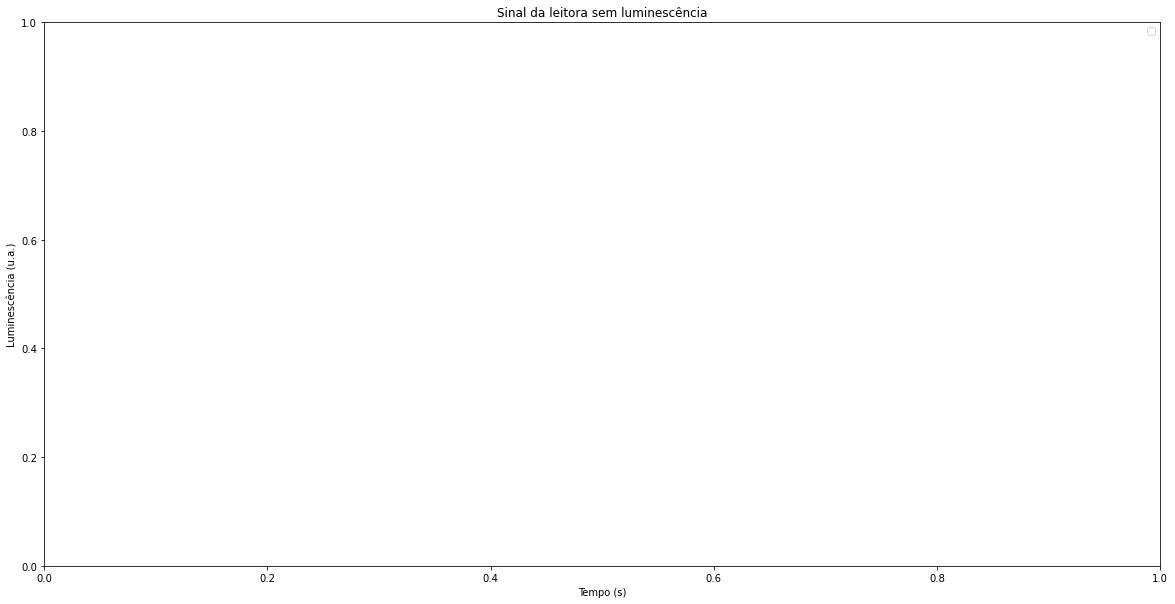

In [33]:
print(len(turned_off_leds.readings))
fig = plt.figure(figsize=(10,5))
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.set_title('Sinal da leitora sem luminescência')
ax.set_xlabel('Tempo (s)')
ax.set_ylabel('Luminescência (u.a.)')
ax.legend(loc='best')
#turned_off_leds.plot(reading_number='all', axis= ax, filter = True)
print(turned_off_leds.mean_integral)

In [15]:
### CALCULATE REPRODUCIBILITY ###
#r = sd/(sqrt(n)*mean)
doses = ['0,1 Gy', '0,3 Gy', '0,5 Gy', '0,7 Gy', '1 Gy', '3 Gy', '5 Gy', '10 Gy']
reproducibility = []
for _ in doses:
    reproducibility.append((data[_].stdv/(math.sqrt(len(data[_].readings))*data[_].mean_integral))*100)

print(reproducibility)

[0.5338754796706668, 0.7162372048098457, 0.8304895808811991, 1.0493678132956803, 1.3011111713004353, 1.4437787633815762, 3.340750611985383, 2.9165717596390945]


In [ ]:
# GERA CURVA DOSE RESPOSTA
doses = ['0,1 Gy', '0,3 Gy', '0,5 Gy', '0,7 Gy', '1 Gy', '3 Gy', '5 Gy', '10 Gy']
osl_mean_total_counts = []
osl_stdv_total_counts = []
for _ in doses:
    osl_mean_total_counts.append(data[_].total_counts/100)
    osl_stdv_total_counts.append(data[_].stdv)


integrais_beatriz = [971.456, 1360.08, 4381.24, 6490.04, 8846.8, 28104.4, 48864.2, 106056]


fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.set_title('Dose-Resposta')
ax.set_xlabel('Dose Irradiada (Gy)')
ax.set_ylabel('Resposta LOE (u.a.)')
#plt.errorbar(doses_beatriz, osl_mean_total_counts, yerr=osl_stdv_total_counts, fmt='o')

ax.scatter(doses, osl_mean_total_counts, label = '$Al_{2}O_{3}$', s = 200, alpha=1)
#ax.scatter(doses_beatriz, integrais_beatriz, color = 'g', marker = '*', label = 'LiF', s = 200)
ax.legend(loc='upper left')
ax.grid(True)

In [ ]:
### CREATE FIGURES ###
doses = ['0,1 Gy', '0,3 Gy', '0,5 Gy', '0,7 Gy', '1 Gy', '3 Gy', '5 Gy', '10 Gy']
for _ in doses:
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    ax.set_title('Resposta OSL para {}'.format(_))
    ax.set_xlabel('Tempo (s)')
    ax.set_ylabel('Luminescência (u.a.)')
    ax.legend(loc='best')

    doses = []
    doses_index = []
    for subdir, dirs, files in os.walk(_):
        dirs.sort()
        for file in files:
            if (file == 'lado 2.txt'):
                base_dir_name = os.path.basename(os.path.dirname(os.path.join(subdir, file)))
                file_path = (os.path.dirname(subdir) + '\\' + base_dir_name + '\\' + file)

                # output_name is used when data is converted to excel files
                output_name = os.path.basename(os.path.dirname(subdir))[8:].replace('_', '-').replace('02', 'fev') + '-' + base_dir_name + '-' + file[:-4]

                dados = osl_response(os.path.abspath(file_path))
                [Tempo, Intensidade] = dados.savgol_filter(51, 3)

                dose = round(dados.total_counts(),4)
                doses.append(dose)
                doses_index.append(base_dir_name)

                ax.plot(Tempo, Intensidade, label = 'Dose = {} - Integral={}'.format(base_dir_name, dose))
                ax.legend()
                plt.savefig(_)



In [ ]:
### CREATE FIGURES ###
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.set_title('Resposta OSL')
ax.set_xlabel('Tempo (s)')
ax.set_ylabel('Luminescência (u.a.)')
ax.legend(loc='best')

doses = []
doses_index = []
for subdir, dirs, files in os.walk('5 Gy'):
    dirs.sort()
    for file in files:
        if (file == 'lado 2.txt'):
            base_dir_name = os.path.basename(os.path.dirname(os.path.join(subdir, file)))
            file_path = (os.path.dirname(subdir) + '\\' + base_dir_name + '\\' + file)

            # output_name is used when data is converted to excel files
            output_name = os.path.basename(os.path.dirname(subdir))[8:].replace('_', '-').replace('02', 'fev') + '-' + base_dir_name + '-' + file[:-4]

            dados = osl_response(os.path.abspath(file_path))
            [Tempo, Intensidade] = dados.savgol_filter(51, 3)

            dose = round(dados.total_counts(),4)
            doses.append(dose)
            doses_index.append(base_dir_name)

            ax.plot(Tempo, Intensidade, label = 'Dose = {} - Integral={}'.format(base_dir_name, dose))
            ax.legend()
            #plt.savefig("teste.png", bbox_inches='tight', dpi=100)


In [ ]:
### CREATE FIGURES ###
fig, axs = plt.subplots(2,2, figsize=(30,20))
#fig.subplots_adjust(hspace=0)
for _ in range (2):
    for count in range (2):
        axs[_][count].set_title('Figura[{}][{}]'.format(_,count))
        axs[_][count].set_xlabel('Tempo (s)\n(a)')
        axs[_][count].set_ylabel('Luminescência (u.a.)')
        axs[_][count].legend(loc='best')
fig.suptitle('Resposta LOE', fontsize = 20)


doses = []
doses_index = []
for subdir, dirs, files in os.walk('5 Gy'):
    dirs.sort()
    for file in files:
        if (file == 'lado 2.txt'):
            base_dir_name = os.path.basename(os.path.dirname(os.path.join(subdir, file)))
            file_path = (os.path.dirname(subdir) + '\\' + base_dir_name + '\\' + file)

            # output_name is used when data is converted to excel files
            output_name = os.path.basename(os.path.dirname(subdir))[8:].replace('_', '-').replace('02', 'fev') + '-' + base_dir_name + '-' + file[:-4]

            dados = osl_response(os.path.abspath(file_path))
            [Tempo, Intensidade] = dados.savgol_filter(51, 3)

            dose = round(dados.total_counts(),4)
            doses.append(dose)
            doses_index.append(base_dir_name)

            axs[0][1].plot(Tempo, Intensidade, label = 'Dose = {} - Integral={}'.format(base_dir_name, dose))
            axs[0][1].legend()
            #plt.savefig("teste.png", bbox_inches='tight', dpi=100)


In [ ]:
### MATPLOTLIB STUDY ###
fig = plt.figure()
ax = plt.subplots(2,2)